<a href="https://www.kaggle.com/sdysch/nlp-disaster-tweets?scriptVersionId=88314845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [162]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [163]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
print(df_train.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


In [164]:
print(df_train.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [165]:
# preprocessing, lower case
df_train['text'] = df_train['text'].str.lower()

In [166]:
# remove URLS
import re

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub(r'', text)

df_train['text'] = df_train['text'].apply(remove_urls)
print(df_train['text'])

0       our deeds are the reason of this #earthquake m...
1                  forest fire near la ronge sask. canada
2       all residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       just got sent this photo from ruby #alaska as ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @thetawniest the out of control w...
7610          m1.94 [01:04 utc]?5km s of volcano hawaii. 
7611    police investigating after an e-bike collided ...
7612    the latest: more homes razed by northern calif...
Name: text, Length: 7613, dtype: object


In [167]:
print(len(df_train))

7613


In [182]:
print(df_train['location'].dropna())

31                         Birmingham
32      Est. September 2012 - Bristol
33                             AFRICA
34                   Philadelphia, PA
35                         London, UK
                    ...              
7575                               TN
7577           #NewcastleuponTyne #UK
7579                Vancouver, Canada
7580                          London 
7581                          Lincoln
Name: location, Length: 5080, dtype: object


In [168]:
# split train into train + testing set, for model validation
# for final submissions, all the training data will be used to fit the model
X = df_train.drop(['target'], axis=1)
y = df_train['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [169]:
# check for class imbalance issues
print(len(y_train[y_train==1]) / len(y_train))
print(len(y_train[y_train==0]) / len(y_train))

print(len(y_test[y_test==1]) / len(y_test))
print(len(y_test[y_test==0]) / len(y_test))

0.4296977660972405
0.5703022339027596
0.42965030372681007
0.57034969627319


* Seems that similar class imbalance is present in testing and training split, likely this is the same in the total sample
* Might want to consider class reweighting in model training

In [170]:
print(X_train)

         id               keyword                        location  \
1279   1842                burned                     Oakland, CA   
6794   9733               tragedy                             NaN   
7456  10671                wounds                    Shady Pines    
1555   2245  chemical%20emergency                 Jersey City, NJ   
6883   9868           traumatised                        Scotland   
...     ...                   ...                             ...   
5226   7470          obliteration                         Merica!   
5390   7691                 panic                             NaN   
860    1242                 blood                             NaN   
7603  10862                   NaN                             NaN   
7270  10409             whirlwind  Stamford & Cork (& Shropshire)   

                                                   text  
1279  burned dog finds new home with young burn victim   
6794  this is a tragedy: i added the wrong book to m...

In [171]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 40
n_words = 100000
tokenizer = Tokenizer(oov_token='<OOV>', num_words=n_words)
tokenizer.fit_on_texts(X_train['text'])
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train['text'])
training_padded = pad_sequences(training_sequences, padding='post', maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(X_test['text'])
testing_padded    = pad_sequences(testing_sequences, padding='post', maxlen=max_length)
print(training_padded.shape)
print(testing_padded.shape)

(1522, 40)
(6091, 40)


In [172]:
print(training_padded.max())

6485


In [173]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, GlobalAveragePooling1D, Dropout
model = Sequential()
model.add(Embedding(n_words, 50, input_length=training_padded.shape[1]))
model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.25))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 50)            5000000   
_________________________________________________________________
global_average_pooling1d_7 ( (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 31        
Total params: 5,001,561
Trainable params: 5,001,561
Non-trainable params: 0
_________________________________________________________________


In [174]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, verbose=1, restore_best_weights=True, mode='auto')
#callbacks = [es]
callbacks = []
    
# model is *really* prone to overfitting, only a few epochs needed
epochs = 4
batch_size = 32

history = model.fit(training_padded,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_split=0.2,
          shuffle=True)

Epoch 1/4
39/39 [==============================] - 2s 37ms/step - loss: 0.6863 - accuracy: 0.5629 - val_loss: 0.6825 - val_accuracy: 0.5574
Epoch 2/4
39/39 [==============================] - 1s 30ms/step - loss: 0.6735 - accuracy: 0.5735 - val_loss: 0.6752 - val_accuracy: 0.5574
Epoch 3/4
39/39 [==============================] - 1s 30ms/step - loss: 0.6538 - accuracy: 0.5801 - val_loss: 0.6587 - val_accuracy: 0.5803
Epoch 4/4
39/39 [==============================] - 1s 27ms/step - loss: 0.6050 - accuracy: 0.6836 - val_loss: 0.6221 - val_accuracy: 0.7115


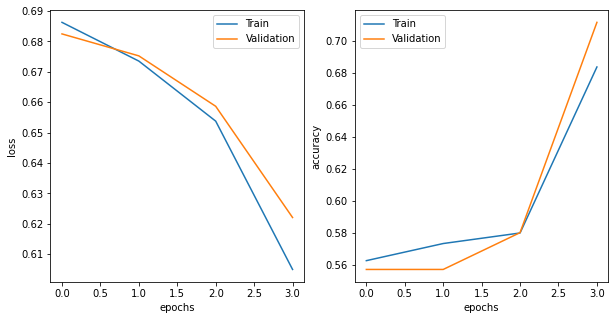

In [175]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'], label='Train')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend(loc='best')


plt.show()

In [178]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import seaborn as sns

y_pred = model.predict(testing_padded)
y_pred = y_pred > 0.5

cm = confusion_matrix(y_test, y_pred, normalize='true')
print(cm)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')

[[0.96459413 0.03540587]
 [0.60756592 0.39243408]]
Accuracy: 0.71876539156132
Precision: 0.8930434782608696
Recall: 0.39243408482995795


In [177]:
"""
y_pred = model.predict(testing_padded)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
sub['target'] = y_pred.round(0).astype('int')
sub.to_csv('submission.csv', index=False)"""

"\ny_pred = model.predict(testing_padded)\ny_pred[y_pred > 0.5] = 1\ny_pred[y_pred <= 0.5] = 0\ny_pred\n\nsub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')\nsub['target'] = y_pred.round(0).astype('int')\nsub.to_csv('submission.csv', index=False)"